In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

from bnpmodeling_runjingdev import log_phi_lib
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

import re

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [93]:
# data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
# out_filename = 'huang2011_fit_sub'
# out_folder = '../fits/tmp/'

data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
out_filename='huang2011_fit'
out_folder='../fits/hgdp_tmp/'

In [94]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# Load data

In [95]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [96]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [97]:
print(n_obs)
print(n_loci)

1107
2810


# Load initial fit

In [98]:
print('initial fit file: ', init_fit_file)

vb_opt_dict, vb_params_paragami, \
        prior_params_dict, prior_params_paragami, \
            gh_loc, gh_weights, init_fit_meta_data = \
                structure_model_lib.load_structure_fit(init_fit_file)

alpha0 = prior_params_dict['dp_prior_alpha']
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

print('Init optim time: {:.3f}secs'.format(init_fit_meta_data['optim_time']))

initial fit file:  ../fits/hgdp_tmp/huang2011_fit_alpha6.0.npz
Init optim time: 4580.959secs


# Define structure objective

In [99]:
stru_objective = s_optim_lib.StructureObjective(g_obs, 
                                                vb_params_paragami,
                                                prior_params_dict, 
                                                gh_loc, gh_weights, 
                                                jit_functions = False)

# check KL's match
kl = stru_objective.f(vb_opt)
diff = np.abs(kl - init_fit_meta_data['final_kl'])
assert diff < 1e-8, diff

# Define perturbation

In [100]:
perturbation = 'sigmoidal_neg'

In [101]:
f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami, 
                                            prior_params_dict['dp_prior_alpha'],
                                            gh_loc, 
                                            gh_weights,
                                            stick_key = 'ind_admix_params')

In [102]:
f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)

# Define linear sensitivity

In [103]:
# cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
#                                             vb_params_paragami,
#                                             return_sqrt = False, 
#                                             return_info = True)

In [104]:
# Define the linear sensitivity class
# vb_sens = HyperparameterSensitivityLinearApproximation(
#                     objective_fun = stru_objective.f, 
#                     opt_par_value = vb_opt, 
#                     hyper_par_value0 = np.array([0.]), 
#                     obj_fun_hvp = stru_objective.hvp, 
#                     hyper_par_objective_fun = f_obj.hyper_par_objective_fun, 
#                     cg_precond = cg_precond, 
#                     cg_tol = 1e-2,
#                     cg_maxiter = None)

# dinput_dfun1 = vb_sens.dinput_dhyper

In [105]:
lr_data = np.load(lr_file)
dinput_dfun1 = lr_data['dinput_dfun_' + perturbation]

In [106]:
lr_data['cg_tol']

array(1.e-08)

In [107]:
lr_data['lr_time_' + perturbation]

array(2433.61634612)

# Compare against actual Hessian inverse

In [108]:
# hvp = jax.jit(lambda v : stru_objective.hvp(vb_opt, v))
# _ = hvp(vb_opt).block_until_ready()

In [109]:
# t0 = time.time()
# kl_hess = jax.lax.map(hvp, np.eye(len(vb_opt)))
# print('Elapsed: ', time.time() - t0)

In [110]:
# cross_hess = vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value,
#                                         vb_sens.hyper_par_value0).squeeze()
# dinput_dfun2 = - np.linalg.solve(kl_hess, cross_hess)

# print(np.abs(dinput_dfun1 - dinput_dfun2).max())

# Load refits

In [111]:
match_crit = out_filename + '_' + perturbation + '\d+.npz'
refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
assert len(refit_files) > 0, 'no refit files found'

In [112]:
def load_refit_files(refit_files): 
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_opt]
    delta = []
    
    for i in range(len(refit_files)): 

        print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        vb_free = vb_params_paragami.flatten(vb_params_dict, free = True)
        
        # check KL
        kl = stru_objective.f(vb_free)
        pert = f_obj.hyper_par_objective_fun(vb_free, meta_data['epsilon']) * \
                meta_data['delta']
        assert np.abs(kl + pert - meta_data['final_kl']) < 1e-8
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_free)
        delta.append(meta_data['delta'])
        
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    delta = np.unique(np.array(delta))
    print('delta = ', delta)
    assert len(delta) == 1
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    return vb_refit_list, epsilon_vec, optim_time_vec, delta

In [113]:
vb_refit_list, epsilon_vec, optim_time_vec, delta = \
    load_refit_files(refit_files)

loading fit from:  huang2011_fit_sigmoidal_neg8.npz
loading fit from:  huang2011_fit_sigmoidal_neg6.npz
loading fit from:  huang2011_fit_sigmoidal_neg1.npz
loading fit from:  huang2011_fit_sigmoidal_neg0.npz
loading fit from:  huang2011_fit_sigmoidal_neg7.npz
loading fit from:  huang2011_fit_sigmoidal_neg9.npz
loading fit from:  huang2011_fit_sigmoidal_neg10.npz
loading fit from:  huang2011_fit_sigmoidal_neg4.npz
loading fit from:  huang2011_fit_sigmoidal_neg3.npz
loading fit from:  huang2011_fit_sigmoidal_neg2.npz
loading fit from:  huang2011_fit_sigmoidal_neg5.npz
delta =  [1.]


In [114]:
epsilon_vec

DeviceArray([0.        , 0.00826446, 0.03305785, 0.07438017, 0.1322314 ,
             0.20661157, 0.29752066, 0.40495868, 0.52892562, 0.66942149,
             0.82644628, 1.        ], dtype=float64)

In [115]:
def predict_opt_par_from_hyper_par(epsilon): 
    return vb_opt + dinput_dfun1 * epsilon * delta

lr_list = []
for epsilon in epsilon_vec: 
    # get linear response
    lr_list.append(predict_opt_par_from_hyper_par(epsilon))


# Define number of clusters

In [116]:
import bnpmodeling_runjingdev.exponential_families as ef
from bnpmodeling_runjingdev import cluster_quantities_lib  

In [117]:
def get_e_ind_admix(vb_free_params, vb_params_paragami): 
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    
    return e_ind_admix
    
def g(vb_free_params, vb_params_paragami): 
    
    e_ind_admix = get_e_ind_admix(vb_free_params, vb_params_paragami)
    
    return cluster_quantities_lib.get_e_num_clusters_from_ez(e_ind_admix)

# Functions to plot results

In [118]:
from tqdm import tqdm

In [119]:
def get_e_num_clusters_vec(param_list): 
    e_num_cluster_vec = onp.zeros(len(param_list))
    for i in tqdm(range(len(param_list))): 
        e_num_cluster_vec[i] = g(param_list[i], vb_params_paragami)
        
    return e_num_cluster_vec

In [120]:
def plot_e_num_clusters(vb_refit_list, lr_list, epsilon_vec, ax): 
        
    assert len(vb_refit_list) == len(lr_list)
    assert len(vb_refit_list) == len(epsilon_vec)
    
    # get expected number of clusters
    print('Computing expected number of clusters ... ')
    
    refit_e_num_clusters_vec = get_e_num_clusters_vec(vb_refit_list)
    lr_e_num_clusters_vec = get_e_num_clusters_vec(lr_list)
    
    # plot
    ax.plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

    ax.plot(epsilon_vec, lr_e_num_clusters_vec, 
               'o-', color = '#1b9e77', 
               label = 'linear approx.')

    ax.legend()
    
    return refit_e_num_clusters_vec, lr_e_num_clusters_vec, epsilon_vec

# Plot results

 50%|█████     | 6/12 [00:00<00:00, 56.91it/s]

Computing expected number of clusters ... 


100%|██████████| 12/12 [00:00<00:00, 60.67it/s]


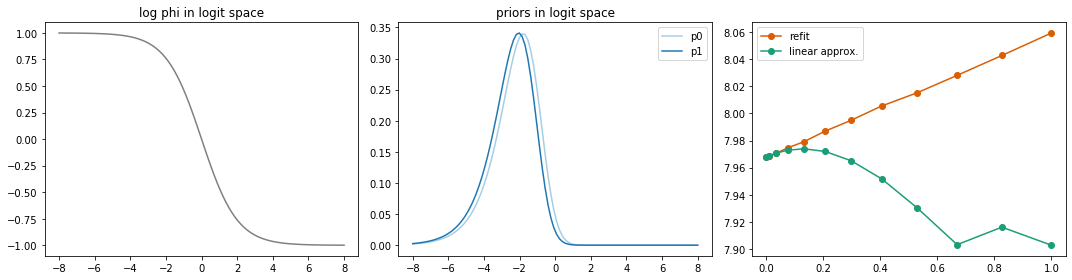

In [121]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 

# plot perturbation
prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = prior_params_dict['dp_prior_alpha'],
                                    log_phi = lambda x : f_obj.log_phi(x) * delta, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
        
# plot log-phi
logit_v_grid = np.linspace(-8, 8, 100)
ax[0].plot(logit_v_grid, 
         prior_perturbation.log_phi(logit_v_grid), 
         color = 'grey')
ax[0].set_title('log phi in logit space')

# plot priors
ax[1].plot(logit_v_grid, 
         np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
         color = '#a6cee3', label = 'p0')
ax[1].plot(logit_v_grid, 
         np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
         color = '#1f78b4', label = 'p1')

ax[1].set_title('priors in logit space')
ax[1].legend()

# plot number of clusters
plot_e_num_clusters(vb_refit_list, lr_list, epsilon_vec, ax[2])

fig.tight_layout()

In [122]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt, ax, color = 'red'): 
    ax.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = color)

    ax.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

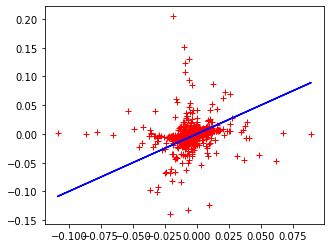

In [123]:
assert np.all(vb_refit_list[0] == lr_list[0])
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
print_diff_plot(lr_list[1], vb_refit_list[1], vb_refit_list[0], ax0, color = 'red')

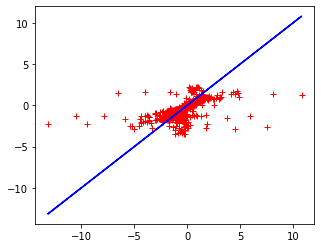

In [124]:
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
print_diff_plot(lr_list[-1], vb_refit_list[-1], vb_refit_list[0], ax0, color = 'red')

# predicted diff in stick means

In [125]:
# free = False means that we are plotting the free parameters (we don't constrain them)
init_stick_means = vb_params_paragami.fold(vb_refit_list[0], free = False)['ind_admix_params']['stick_means']
lr_stick_means = vb_params_paragami.fold(lr_list[1], free = False)['ind_admix_params']['stick_means']
refit_stick_means = vb_params_paragami.fold(vb_refit_list[1], free = False)['ind_admix_params']['stick_means']

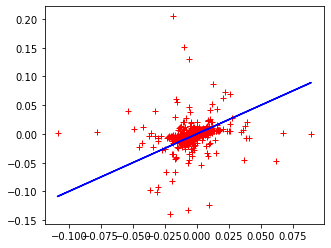

In [126]:
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
print_diff_plot(lr_stick_means.flatten(),
                refit_stick_means.flatten(), 
                init_stick_means.flatten(), ax0, color = 'red')

# Predicted diff in stick infos

In [127]:
epsilon_vec[1]

DeviceArray(0.00826446, dtype=float64)

In [128]:
init_stick_infos = vb_params_paragami.fold(vb_refit_list[0], free = False)['ind_admix_params']['stick_infos']
lr_stick_infos = vb_params_paragami.fold(lr_list[1], free = False)['ind_admix_params']['stick_infos']
refit_stick_infos = vb_params_paragami.fold(vb_refit_list[1], free = False)['ind_admix_params']['stick_infos']

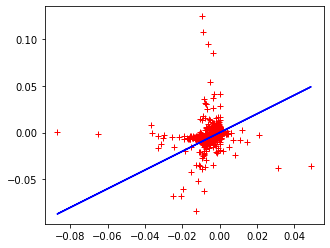

In [129]:
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
print_diff_plot(lr_stick_infos.flatten(),
                refit_stick_infos.flatten(), 
                init_stick_infos.flatten(), ax0, color = 'red')

# Effect on logitnormal mean parameter. 
LR should be linear here

In [130]:
def plot_stick_components(stick_fun, n_indx, k_sub = 6): 
    refit_array = []
    lr_array = []

    for i in range(len(epsilon_vec)): 
        refit_array.append(stick_fun(vb_refit_list[i]))
        lr_array.append(stick_fun(lr_list[i]))

    lr_array = np.array(lr_array)
    refit_array = np.array(refit_array)
    
    for n in n_indx: 

        fig, ax = plt.subplots(1, k_sub, figsize = (24, 4))
        fig.tight_layout()

        for k in range(k_sub): 
            ax[k].plot(epsilon_vec, lr_array[:, n, k], '-x', color = 'red')
            ax[k].plot(epsilon_vec, refit_array[:, n, k], '-x', color = 'blue')

[599]


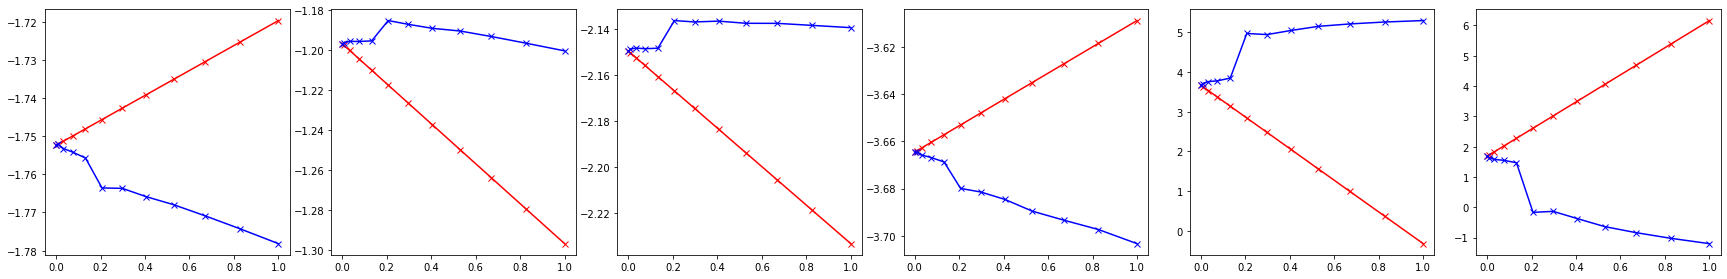

In [131]:
obs_indx = [599] # onp.random.choice(g_obs.shape[0], (1,))
print(obs_indx)

def get_logitnormal_mean_param(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    return vb_params_dict['ind_admix_params']['stick_means']

plot_stick_components(get_logitnormal_mean_param, obs_indx)

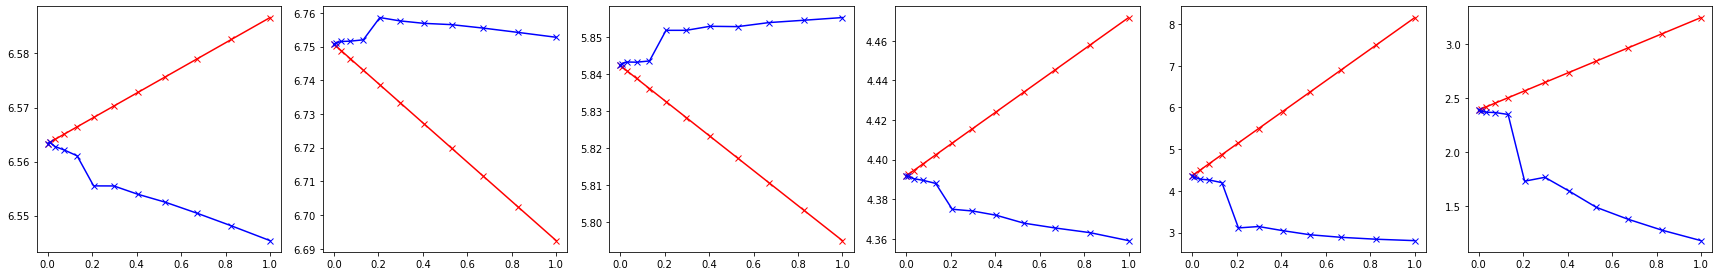

In [132]:
def get_logitnormal_info_param(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    return np.log(vb_params_dict['ind_admix_params']['stick_infos'])

plot_stick_components(get_logitnormal_info_param, obs_indx)

# On expectation of sticks

In [133]:
def get_e_sticks(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    lognorm_means = vb_params_dict['ind_admix_params']['stick_means']
    lognorm_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return ef.get_e_logitnormal(lognorm_means, lognorm_infos, gh_loc, gh_weights)

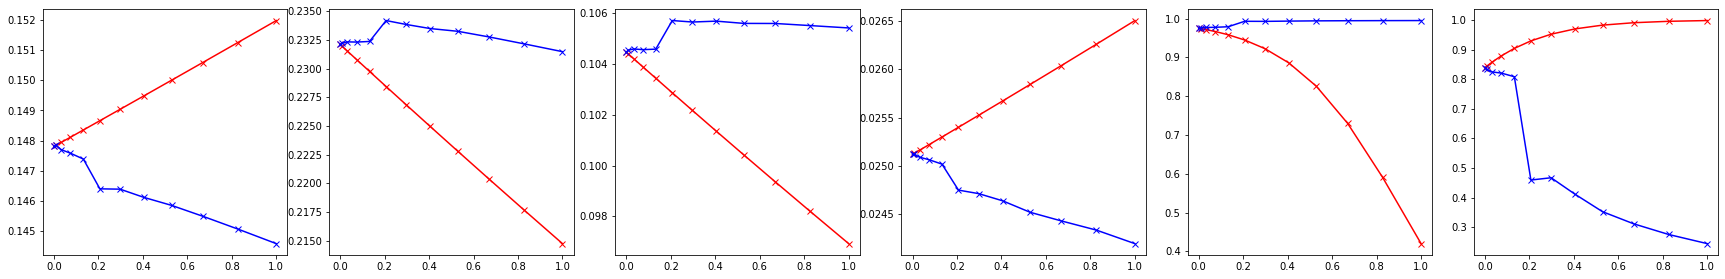

In [134]:
plot_stick_components(get_e_sticks, obs_indx)

# On mixture proportions

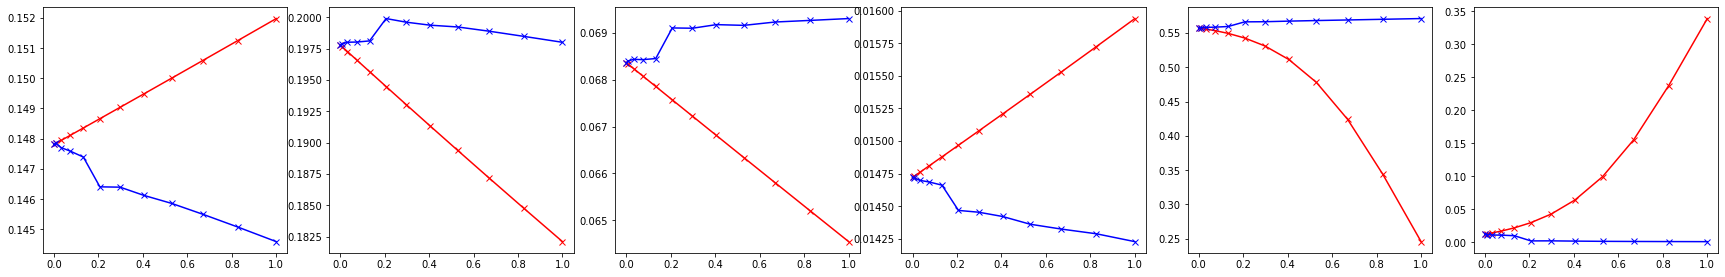

In [135]:
plot_stick_components(lambda x : get_e_ind_admix(x, vb_params_paragami), 
                      obs_indx)

In [81]:
diff = get_e_ind_admix(vb_refit_list[-1], vb_params_paragami) - \
            get_e_ind_admix(lr_list[-1], vb_params_paragami)

In [84]:
diff.flatten()

DeviceArray([-1.79243742e-02,  7.29868768e-04,  1.16133557e-03, ...,
              6.81111259e-05,  6.41828737e-05,  1.03845956e-03],            dtype=float64)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+01, 2.1787e+04,
        3.1300e+02, 3.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-0.72231758, -0.57303479, -0.42375201, -0.27446922, -0.12518643,
         0.02409635,  0.17337914,  0.32266193,  0.47194472,  0.6212275 ,
         0.77051029]),
 <a list of 10 Patch objects>)

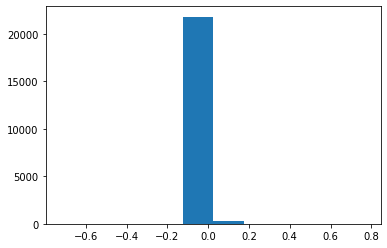

In [85]:
plt.hist(diff.flatten())

In [86]:
np.where(diff > 0.5)

(DeviceArray([599, 914, 922, 973], dtype=int64),
 DeviceArray([4, 2, 2, 2], dtype=int64))